<a href="https://colab.research.google.com/github/mehraj-alom/pytorch/blob/main/Training_with_custom_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn
torch.__version__

'2.8.0+cu126'

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# . Get data

In [3]:
# Food Vision

In [4]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [5]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [6]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi/test/steak/673127.jpg
Image class: steak
Image height: 512
Image width: 512


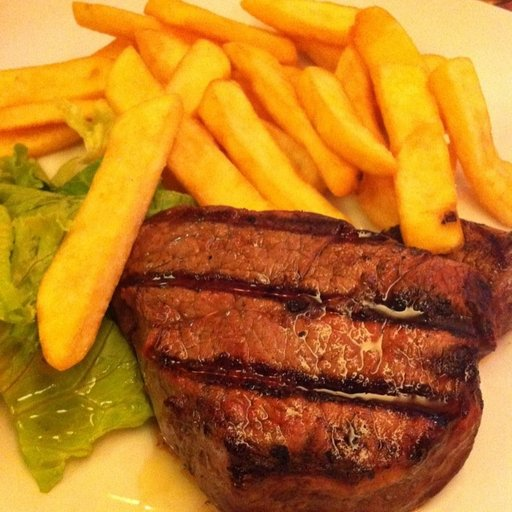

In [7]:
import random
from PIL import Image

#random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

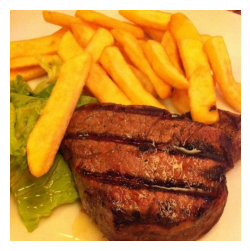

In [8]:
import matplotlib.pyplot as plt
import numpy as np
img_to_arr = np.asarray(img)

plt.figure(figsize=(7,3))
plt.imshow(img_to_arr)
plt.axis("off")
plt.show()

# Transforming data

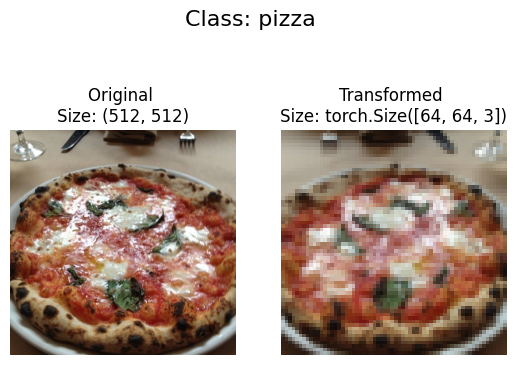

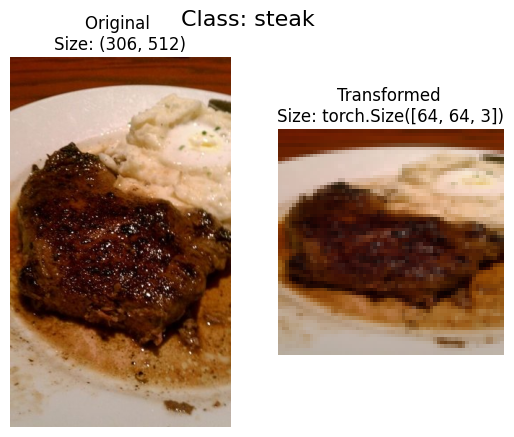

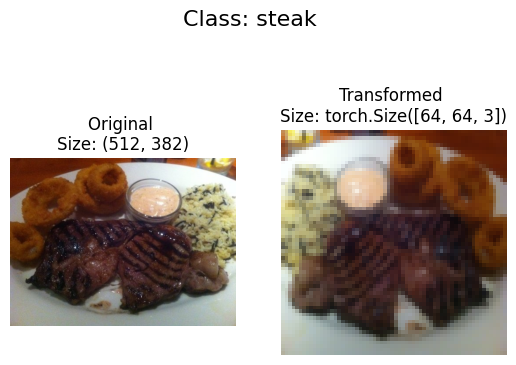

In [9]:
from torch.utils.data import DataLoader
from torchvision import datasets , transforms
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths,k=n)
    for image_path in random_image_paths:
      with Image.open(image_path) as f:
        fig , ax = plt.subplots(1,2)
        ax[0].imshow(f)
        ax[0].set_title(f"Original \nSize: {f.size}")
        ax[0].axis("off")

        transformed_image = transform(f).permute(1, 2, 0)
        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
        ax[1].axis("off")

        fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3)

# Loading Image Data Using `ImageFolder`

In [10]:
from torchvision import datasets
train_data = datasets.ImageFolder(
    root = train_dir,
    transform=data_transform,
    target_transform=None
)
test_data = datasets.ImageFolder(
    root = test_dir,
    transform=data_transform
)
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [11]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [12]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [13]:

len(train_data), len(test_data)

(225, 75)

In [14]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

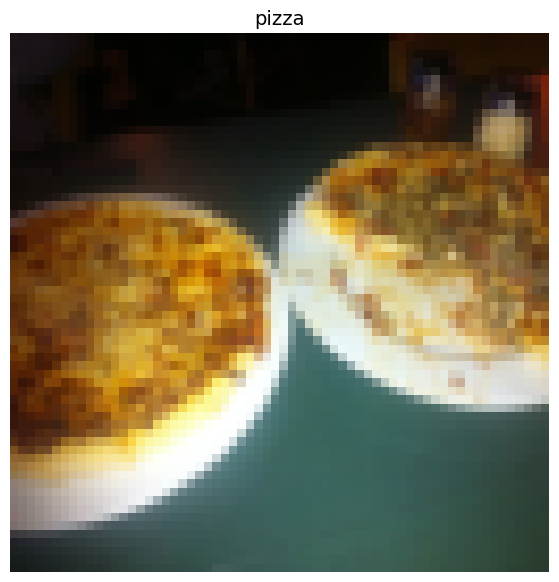

In [15]:
img_permute = img.permute(1,2,0)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

In [16]:
from torch.utils.data import DataLoader
train_DataLoader = DataLoader(dataset=train_data,
                              batch_size=2,
                              num_workers=2,
                              shuffle=True)
test_DataLoader = DataLoader(dataset=test_data,
                             batch_size=2,
                             num_workers=2,
                             shuffle=False)

train_DataLoader, test_DataLoader

(<torch.utils.data.dataloader.DataLoader at 0x7ebca49b36b0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ebc9b880770>)

In [17]:
img, label = next(iter(train_DataLoader))
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([2, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([2])


# Option 2: Loading Image Data with a Custom Dataset

To see this in action, let's work towards replicating torchvision.datasets.ImageFolder() by subclassing torch.utils.data.Dataset (the base class for all Dataset's in PyTorch).

We'll start by importing the modules we need:

Python's os for dealing with directories (our data is stored in directories).
Python's pathlib for dealing with filepaths (each of our images has a unique filepath).
torch for all things PyTorch.
PIL's Image class for loading images.
torch.utils.data.Dataset to subclass and create our own custom Dataset.
torchvision.transforms to turn our images into tensors.
Various types from Python's typing module to add type hints to our code.

In [18]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [19]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

 * Creating a helper function to get class names

In [20]:
target_directory = train_dir
print(f"Target dir : {target_directory}")

class_names_found = sorted([entry.name for entry in list(os.scandir(image_path/"train"))])
print(f"Class names found: {class_names_found}")

Target dir : data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [21]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

- **Create a custom Dataset to replicate ImageFolder**

In [24]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  """
    Custom Dataset to replicate torchvision.datasets.ImageFolder().

    This class provides a flexible way to load image data when your data
    doesn't fit the standard `torchvision.datasets.ImageFolder` structure
    or requires custom loading and preprocessing.

    You should consider overwriting the `torch.utils.data.Dataset` class
    by creating your own subclass when:

    1.  **Your data is in a custom format:** If your images are not organized
        in the standard `root/class_name/image.jpg` structure, or if you have
        additional data associated with each image (like metadata), a custom
        Dataset allows you to define how to load and access this data.

    2.  **You need complex preprocessing:** If the required data
        transformations are not covered by the standard `torchvision.transforms`,
        you can implement your own preprocessing logic within the `__getitem__`
        method. This is useful for custom augmentations, normalization schemes,
        or loading data from non-image sources.

    3.  **You need to load data on the fly:** For very large datasets that
        cannot fit into memory, or when you want to generate data dynamically
        during training (e.g., synthetic data), a custom Dataset allows you to
        load and process data samples as they are needed by the DataLoader.

    4.  **You want to integrate with custom data sources:** If your data is
        stored in a database, cloud storage, or any other non-file system
        location, a custom Dataset is necessary to define how to retrieve
        data samples from these sources.

    Args:
        tar_dir (str): Target directory to load images from.
        transforms (callable, optional): Optional transform to be applied
            on a sample. Defaults to None.
    """
  def __init__(self,tar_dir:str,transforms = None) ->None:
    self.paths = list(pathlib.Path(tar_dir).glob("*/*.jpg"))
    self.transform = transforms
    self.classes , self.class_to_idx = find_classes(tar_dir)

  def load_image(self, index : int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self)-> int:
    return len(self.paths)

  def __getitem__(self, index : int) -> tuple[torch.Tensor,int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # Corrected line
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img),class_idx
    else:
      return img,class_idx

- Transformation to be applied on both train and test data

In [28]:
train_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [29]:
train_data_custom = ImageFolderCustom(tar_dir=train_dir,
                                      transforms=train_transforms)
test_data_custom = ImageFolderCustom(tar_dir=test_dir,
                                     transforms=test_transforms)
train_data_custom,test_data_custom

(<__main__.ImageFolderCustom at 0x7ebc8457a990>,
 <__main__.ImageFolderCustom at 0x7ebc84960260>)

In [31]:
len(train_data_custom),len(test_data_custom)

(225, 75)

In [32]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [33]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [34]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True



**5.3 Create a function to display random images**

In [39]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes : list[str] = None,
                          n : int = 10 ,
                          display_shape : bool = True ,
                          seed : int = None):
  '''
  args :
       dataset : torch.utils.data.Dataset
       classes : list[str]
       n : int
       display_shape : bool
       seed : int

  '''
  if n > 10 :
    n = 10
    display_shape = False
    print("Plotting only 10 coz display might go out of hand ")
  if seed :
    torch.manual_seed(seed)

  random_sample_idx = random.sample(range(len(dataset)),k = n)

  plt.figure(figsize=(16,8))


  for i , targ_sample in enumerate(random_sample_idx):
    targ_image , targ_label = dataset[targ_sample][0],dataset[targ_sample][1]
    #Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
    targ_image_adjust = targ_image.permute(1, 2, 0)
    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"class :{classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

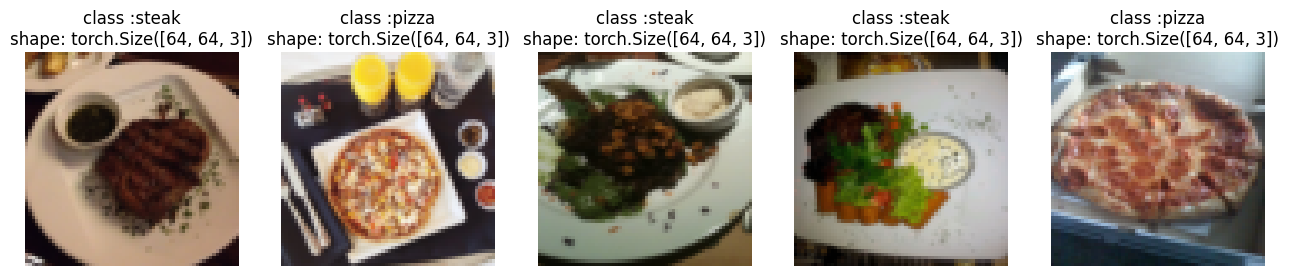

In [44]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)